In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
data = np.load('data.npy', allow_pickle = True)

In [4]:
print(data.shape) # printing the dimensions of data

(1500, 5)


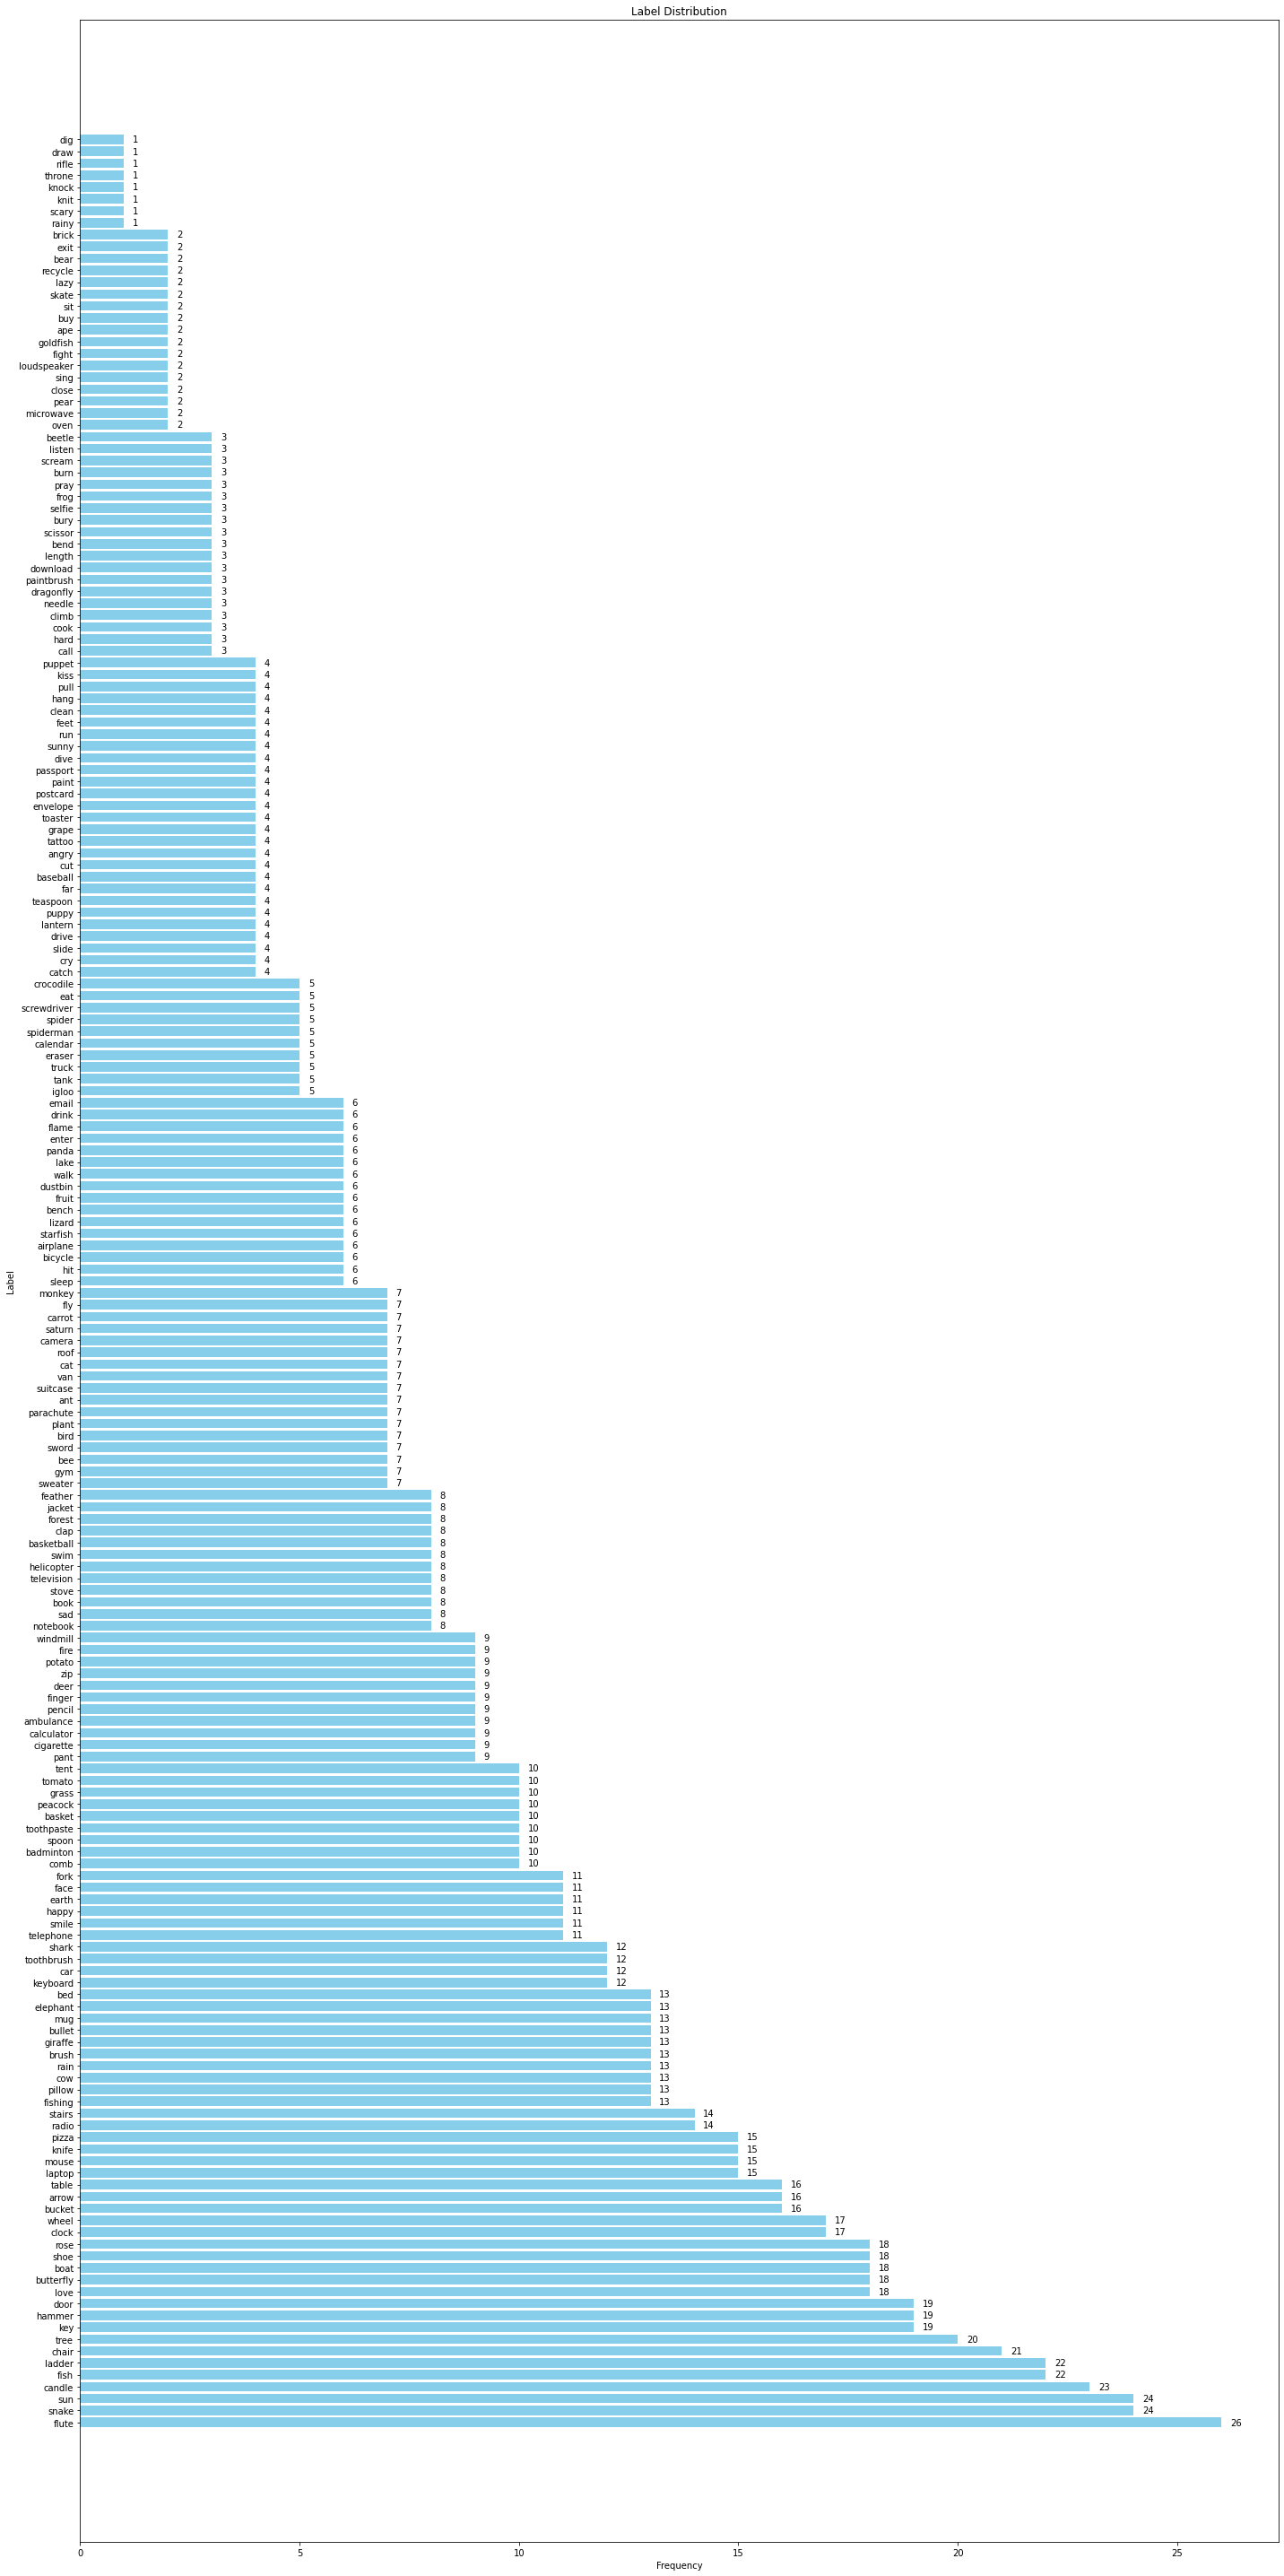

In [5]:
labels = data[:, 3]

# Count label occurrences using a dictionary
label_counts = {}
for label in labels:
    label_counts[label] = label_counts.get(label, 0) + 1

# Sort labels by frequency
sorted_labels = sorted(label_counts.keys(), key=lambda x: label_counts[x], reverse=True)
sorted_frequencies = [label_counts[label] for label in sorted_labels]

# Create a horizontal bar plot
plt.figure(figsize=(20, 40))
bars = plt.barh(sorted_labels, sorted_frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Label')
plt.title('Label Distribution')
for bar, frequency in zip(bars, sorted_frequencies):
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2,
             str(frequency), va='center', color='black')
plt.tight_layout()

plt.show()

In [12]:
import random
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

class KNN:
    def _init_(self): # Initialize the kNN classifier's parameters with none
        self.encoder_type = None
        self.k = None
        self.distance_metric = None
        self.data = None

    def setParameters(self, encoder_type, k, distance_metric): # set the parameters of the kNN classifier
        self.encoder_type = encoder_type
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, data): # fit the kNN classifier
        self.data = data

    # Mini problem statement run on Chatgpt:
    # Given x1 which is our query point (consisting of embeddings in a form of list in case of ViT : 512 and in Resnet: 1024) 
    # and x2 which is a list of elements of training data each containing embeddings.
    # Calculate the distance between each element of x2 and x1 and append the distance to a global distances list. Do this optimally
    # using numpy functions (to ensure vectorization).

    # Suggestion/Answer:
    # Convert the list of all the elements containing embeddings (1200 1-d lists of size 512 each in case of ViT and of size 1024
    # in case of Resnet) to a 2d array of 1200*512 or 1200*1024 shape so we can support matrix operations over them.
    # To do so use np.vstack() and then do normal distance metric wise calculations.

    def euclidean_distance(self, x1, x2): 
        query_point = x1
        embeddings = x2
        # print(self.encoder_type, x1.shape) # If encoder is ViT : x1.shape will be 1*512, and if Resnet x1.shape will be 1*1024.

        embeddings_array = np.vstack(embeddings) # used gpt's suggestion as described above.
        squared_diffs = (embeddings_array - query_point) ** 2

        # By summing along axis=-1, we are effectively summing the squared differences for each embedding vector 
        # separately, resulting in an array of squared Euclidean distances, where each element corresponds
        # to the distance between the query_point and the corresponding embedding vector. Suggested for vectorization and
        # optimal distance calculation without using loops.
        squared_distances = np.sum(squared_diffs, axis=-1)

        euclidean_distances = squared_distances ** 0.5 
        return euclidean_distances

    def manhattan_distance(self, x1, x2):
        # Calculate the mahattan distance the same way used for calculating euclidean distances.
        query_point = x1
        embeddings = x2
        embeddings_array = np.vstack(embeddings)
        manhattan_distances = np.sum(np.abs(embeddings_array - query_point), axis=-1)
        return manhattan_distances
    
    def cosine_distance(self, x1, x2):
        # Calculate the cosine distance the same way used for calculating euclidean distances.
        query_point = x1
        embeddings = x2
        embeddings_array = np.vstack(embeddings)
        dot_product = np.dot(embeddings_array, query_point)
        query_magnitude = np.linalg.norm(query_point)
        embedding_magnitudes = np.linalg.norm(embeddings_array, axis=1)
        cosine_similarity = dot_product / (embedding_magnitudes * query_magnitude)
        cosine_distances = 1 - cosine_similarity
        return cosine_distances

    def predict(self, query_point):
        distances = []
        # If the encoder type set is resnet we will consider the 1st column of each element belonging to the training data
        # and if encoder type is ViT, we consider the 2nd column (0-based indexing), these will be our embeddings.
        if self.encoder_type == 'resnet':
            embeddings = self.data[:, 1]
        else:
            embeddings = self.data[:, 2]
        labels = self.data[:, 3] # Extract all the labels from the training data.

        # Now we want to calculate the distance between the query point and all the embeddings in the training data.
        if self.distance_metric == 'euclidean':
            distances = self.euclidean_distance(query_point, embeddings)
        elif self.distance_metric == 'manhattan':
            distances = self.manhattan_distance(query_point, embeddings)
        else:
            distances = self.cosine_distance(query_point[0], embeddings)

        # We now have all the distances from each and every element (single embedding vector) from our query point.
        distances = np.column_stack((distances, labels)) # Combine the distance with labels as we want to predict the label.

        sorted_indices = np.argsort(distances[:, 0]) # Sort the distances based on the distance parameter.
        k_nearest_indices = sorted_indices[:self.k] # We need to consider the k nearest distance, label pairs for prediction of the label.
        k_distance_labels = distances[k_nearest_indices]

        # Below is an optimization to naive kNN classification : Weighted voting to break ties. (with distance parameter)
        # Description: Assume k is 7 and you have 7 distance, label pairs with 3 labels occuring twice and one label occuring once.
        # In naive kNN we would have just considered the label which occured the maximum times : so since here there are 3 labels 
        # which occur 2 times, it would have randomly picked any 1 of these 3 labels. But this process can be improved using weighted
        # voting, to break ties and assign a class label, we will use each neighbor's vote, which is weighted based on its
        # proximity to the query point.

        # Chatgpt prompt : How to make a list containing of (param, label) where param is 1/(distance_corresponding_to_that_label + 1)
        # and then sum the param's for all the same labels to store in a new list and then get the maximum pair in the new list. 

        inverse_distances = 1.0 / (k_distance_labels[:, 0] + 1).astype(float) # All the inverse distances (+1) is done to ensure zero division does not occur.
        invlabels = k_distance_labels[:, 1]

        # np.unique(invlabels, return_inverse=True) returns a tuple with two arrays:
        # unique_labels contains the unique labels present in invlabels.
        # label_inverse is an array that maps each label in invlabels to its corresponding index in unique_labels.

        unique_labels, label_inverse = np.unique(invlabels, return_inverse=True)

        # GPT: Calculate the sum of inverse_distances for each unique label index in label_inverse.
        # Suggestion using np.bincount with extra parameter passed as weights which is our inverse_distances list.
        inverse_sum = np.bincount(label_inverse, weights=inverse_distances)

        max_vote_index = np.argmax(inverse_sum) # Get the index of the label with the maximum sum of param (1/dist+1) implying
        # the label which is closest to the query_point.
         
        prediction = unique_labels[max_vote_index]
        # return the predicted label.
        return prediction 
 
    def evaluate(self, validation_data): # evaluate the perfomance of the kNN classifier with given parameters on the validation data.
        true_labels = validation_data[:, 3] # extract all the labels present in the validation data
        predicted_labels = []
        for row in validation_data:
            # If the encoder type set is resnet we will consider the 1st column of each element belonging to the validation data
            # and if encoder type is ViT, we consider the 2nd column (0-based indexing).
            if self.encoder_type == 'resnet':
                query_point = row[1]
            else:
                query_point = row[2]
            
            predicted_label = self.predict(query_point) # Predict the label for this query_point using predict method described above.
            predicted_labels.append(predicted_label)

        # Used sklearn metrics to get the following scores. 
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted',zero_division =1)
        recall = recall_score(true_labels, predicted_labels, average='weighted',zero_division=1)
        f1 = f1_score(true_labels, predicted_labels, average='weighted',zero_division=1)
        return accuracy, precision, recall, f1

In [16]:
# [Use allow_pickle = true because we are willing to load objects that have been serialized using the pickle module.]
data = np.load('data.npy', allow_pickle = True)
random.shuffle(data)
random.shuffle(data)
random.shuffle(data)
split_point = int(0.8 * len(data))
train_data, validation_data = data[:split_point], data[split_point:] # split the data into training and testing data with 4:1 ratio.
encoders = ['vit','resnet'] # list of encoders
distance_metrics = ['euclidean', 'manhattan','cosine'] # list of distance_metrics to be considered
max_accuracy = -1; hyper_enc = "None" ; hyper_k = 0; hyper_dist = "Nonedist"
knn_model = KNN()
knn_model.fit(train_data)
results = []
spec_accuracy = []

sklearn_knn_model = KNeighborsClassifier()

# Lists to store results for plotting
inference_times_knn = []
inference_times_sklearn = []

st_time = time.time()

# Iterate over all possible triplets of [encoder, distance_metric, k] for hyperparameter tuning.
for i in encoders:
    for j in distance_metrics:
        for k in range(1,35):
            fl = 0
            # Just for plotting purposes extract the accuracies when the encoder is vit and distance_metric is euclidean.
            if i == 'vit' and j == 'euclidean':
                fl = 1
            parameters = [k,i,j]
#             s = time.time()
            knn_model.setParameters(i,k,j) # set the parameters of the kNN classifier
            accuracy, precision, recall, f1 = knn_model.evaluate(validation_data) # evaluate the performance of the classifier on validation data
            results.append((parameters, accuracy))
#             e = time.time() - s
#             print(e, accuracy)
            if fl == 1:
                spec_accuracy.append((k,accuracy))
en_time = time.time()
# print("Total execution time: ", en_time - st_time)
top_performing = sorted(results, key=lambda x: x[1], reverse=True)[:20] # extract the top 20 triplets sorted by accuracy (large to small)

Best Triplet:
accuracy = 0.84
k = 1
distance metric = manhattan
encoder = vit
Rank       K               Encoder         Distance Metric Accuracy       
1          1               vit             manhattan       0.84           
2          2               vit             manhattan       0.84           
3          1               vit             euclidean       0.8366666666666667
4          2               vit             euclidean       0.8366666666666667
5          1               vit             cosine          0.8366666666666667
6          2               vit             cosine          0.8366666666666667
7          3               vit             euclidean       0.8333333333333334
8          3               vit             manhattan       0.8333333333333334
9          4               vit             manhattan       0.8333333333333334
10         4               vit             euclidean       0.83           
11         5               vit             manhattan       0.83           
1

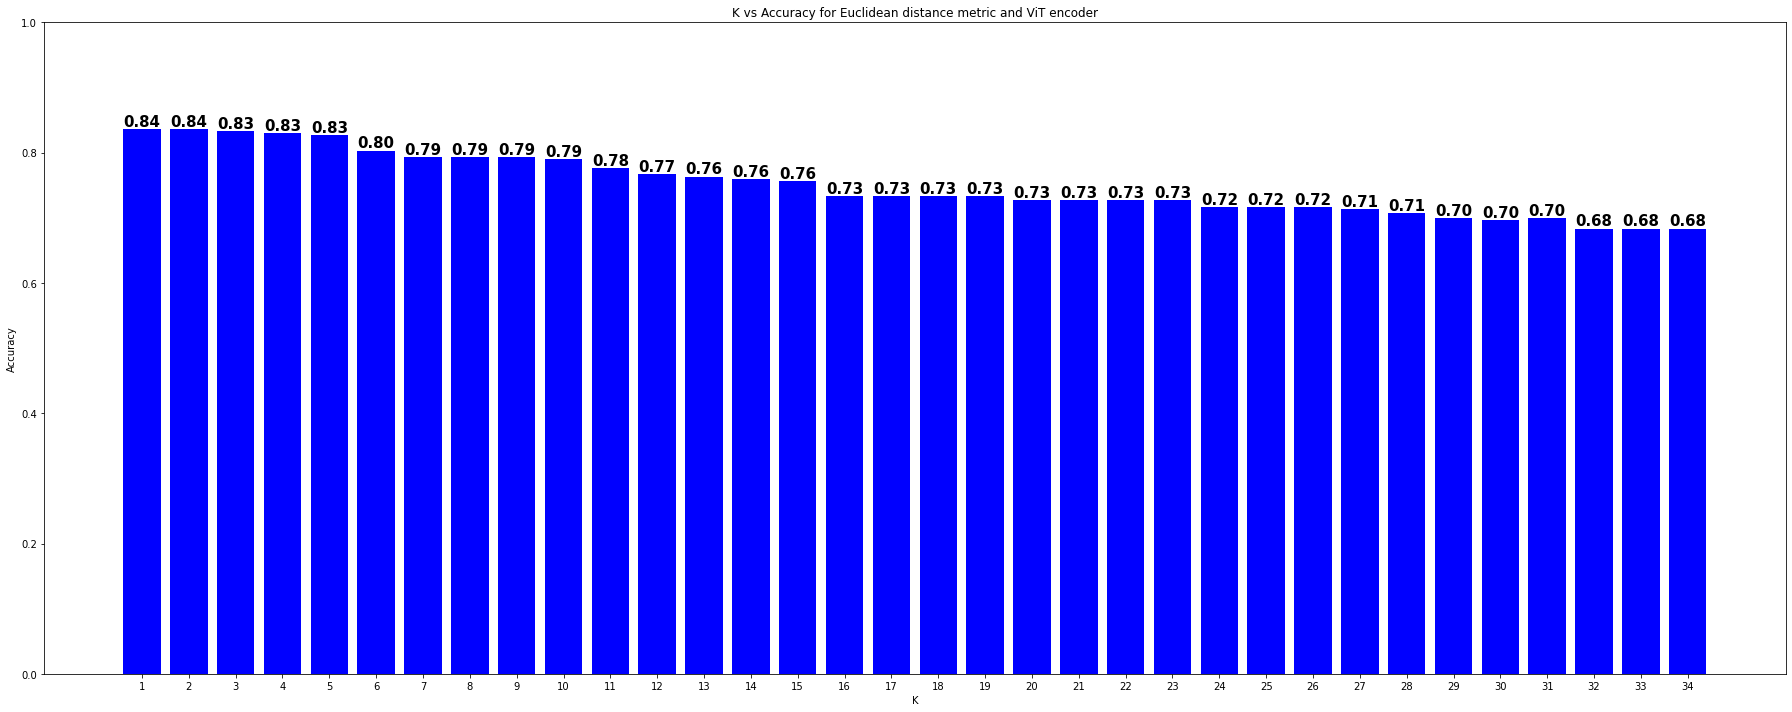

In [17]:
print("=" * 80)
print("Best Triplet:")
params, accuracy = top_performing[0]
print("accuracy =", accuracy)
print("k =", params[0])
print("distance metric =", params[2])
print("encoder =", params[1])
print("=" * 80)

print("{:<10} {:<15} {:<15} {:<15} {:<15}".format("Rank", "K", "Encoder", "Distance Metric", "Accuracy"))

for rank, (params, accuracy) in enumerate(top_performing, start=1):
    k, encoder, distance_metric = params
    print("{:<10} {:<15} {:<15} {:<15} {:<15}".format(rank, k, encoder, distance_metric, accuracy)) # Used gpt for this neat printing format.
print("=" * 80)
ks, accuracies = zip(*spec_accuracy)

plt.figure(figsize=(25, 10))
bars = plt.bar(ks, accuracies, color='blue')

# Plotting the K vs accuracy plot for euclidean distance metric and ViT encoder.
plt.title('K vs Accuracy for Euclidean distance metric and ViT encoder')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set the y-axis limits

# Display the accuracy over all the bars (gpt suggestion using plt.text with given height)
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}', ha='center', va='bottom',weight='bold', fontsize=15)

plt.xticks(ks)
plt.tight_layout()

plt.show()

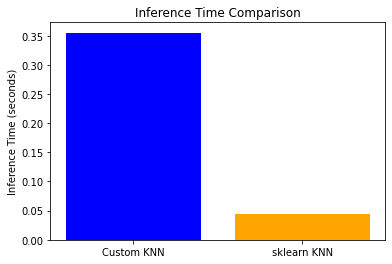

In [70]:
knn_model = KNN()
knn_model.fit(train_data)
knn_model.setParameters('resnet', 5, 'manhattan')
sklearn_knn_model = KNeighborsClassifier(n_neighbors=5, metric='manhattan')

inference_times_knn = []
inference_times_sklearn = []

encoder = 'vit'

# Get the corresponding column index for the encoder in the data
encoder_column_index = 1 if encoder == 'resnet' else 2

# Extract validation data for the chosen encoder
x_val = []
for row in validation_data:
    # If the encoder type set is resnet we will consider the 1st column of each element belonging to the validation data
    # and if encoder type is ViT, we consider the 2nd column (0-based indexing).
    if encoder == 'resnet':
        query_point = row[1]
    else:
        query_point = row[2]
    x_val.append(query_point)
    
x_val = np.array(x_val)
x_val = x_val.reshape(x_val.shape[0], -1)  # Reshape to (300, 512)
y_val = np.array([row[3] for row in validation_data])

# Measure inference time for my KNN model
knn_model.setParameters(encoder, k, distance_metric)
knn_model.fit(train_data)
start_time = time.time()
knn_model.evaluate(validation_data)
end_time = time.time()
inference_time_knn = end_time - start_time
inference_times_knn.append(inference_time_knn)

# Measure inference time for sklearn KNN model
sklearn_knn_model.fit(x_val, y_val)
start_time = time.time()
sklearn_knn_model.predict(x_val)
end_time = time.time()
inference_time_sklearn = end_time - start_time
inference_times_sklearn.append(inference_time_sklearn)

# Plot the bar graph
models = ['Custom KNN', 'sklearn KNN']
inference_times = [inference_time_knn, inference_time_sklearn]
plt.bar(models, inference_times, color=['blue', 'orange'])
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison')
plt.show()

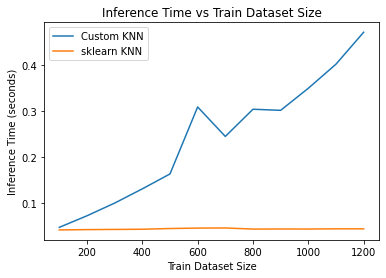

In [84]:
# Fixed hyperparameters
distance_metric = 'manhattan'
k = 5
encoder = 'vit'

# Create instances of your KNN model and sklearn KNN model
knn_model = KNN()
sklearn_knn_model = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)

# Initialize lists to store train dataset sizes and inference times
train_sizes = []
inference_times_knn = []
inference_times_sklearn = []

# Generate random indices for train data
random_indices = list(range(len(train_data)))

# Loop to increase train dataset size
for i in range(100, 1201, 100):
    train_indices = random.sample(random_indices, i)
    current_train_data = [train_data[idx] for idx in train_indices]
    current_train_data = np.array(current_train_data)
#     print(current_train_data.shape)
    x_val = []
    for row in validation_data:
        # If the encoder type set is resnet we will consider the 1st column of each element belonging to the validation data
        # and if encoder type is ViT, we consider the 2nd column (0-based indexing).
        if encoder == 'resnet':
            query_point = row[1]
        else:
            query_point = row[2]
        x_val.append(query_point)

    x_val = np.array(x_val)
    x_val = x_val.reshape(x_val.shape[0], -1)  # Reshape to (300, 512)
    y_val = np.array([row[3] for row in validation_data])

    # Measure inference time for my KNN model
    knn_model.setParameters(encoder, k, distance_metric)
    knn_model.fit(current_train_data)
    start_time = time.time()
    knn_model.evaluate(validation_data)
    end_time = time.time()
    inference_time_knn = end_time - start_time
    inference_times_knn.append(inference_time_knn)
    train_sizes.append(i)

    # Measure inference time for sklearn KNN model
    sklearn_knn_model.fit(x_val, y_val)
    start_time = time.time()
    sklearn_knn_model.predict(x_val)
    end_time = time.time()
    inference_time_sklearn = end_time - start_time
    inference_times_sklearn.append(inference_time_sklearn)

# Plot the graph
plt.plot(train_sizes, inference_times_knn, label='Custom KNN')
plt.plot(train_sizes, inference_times_sklearn, label='sklearn KNN')
plt.xlabel('Train Dataset Size')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time vs Train Dataset Size')
plt.legend()
plt.show()

## DECISION TREE POWERSET CODE BELOW

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder, StandardScaler
from skmultilearn.problem_transform import LabelPowerset
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, hamming_loss,precision_score,recall_score
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [86]:
# MultiLabelDecisionTree

class MLDT:
    def __init__(self, max_depth=None, max_features=None, criterion='gini'): # Initialize the parameters of DecisionTreeClassifier to None
        self.max_depth = None
        self.max_features = None
        self.criterion = None
        
    def set_params(self, depth, features, criteria): # Set the parameters of DecisionTreeClassifier
        self.max_depth = depth
        self.max_features = features
        self.criterion = criteria
    
    def build_classifier(self): # Instantiate the DecisionTreeClassifier of sklearn 
        self.classifier = DecisionTreeClassifier(
            max_depth = self.max_depth,
            max_features = self.max_features,
            criterion = self.criterion
        )

    def fit(self, X, y): # Fit the classifier to X_train and y_train data
        self.classifier.fit(X, y)

    def predict(self, X): # Predict wrapper to DecisionTreeClassifier's predict method
        return self.classifier.predict(X)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        report = classification_report(y, y_pred,zero_division=1)
        return report

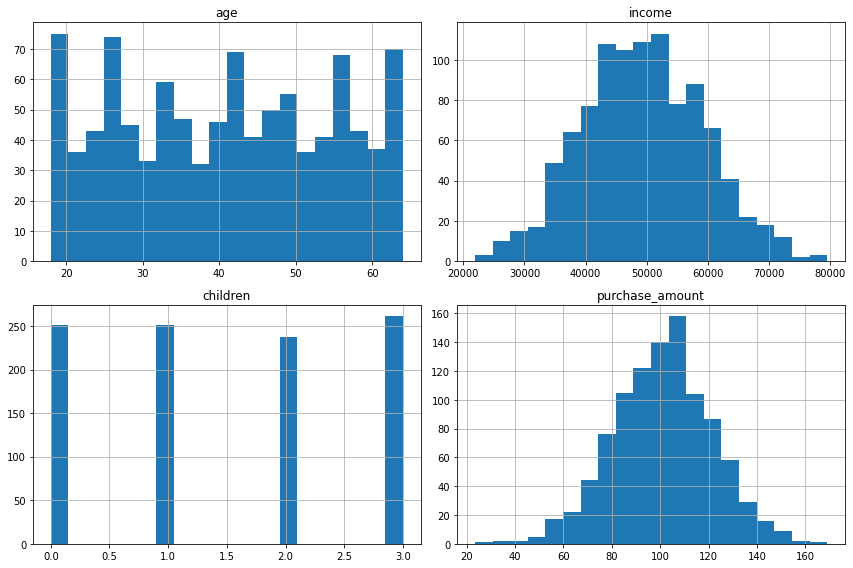

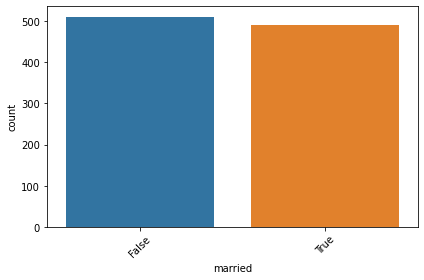

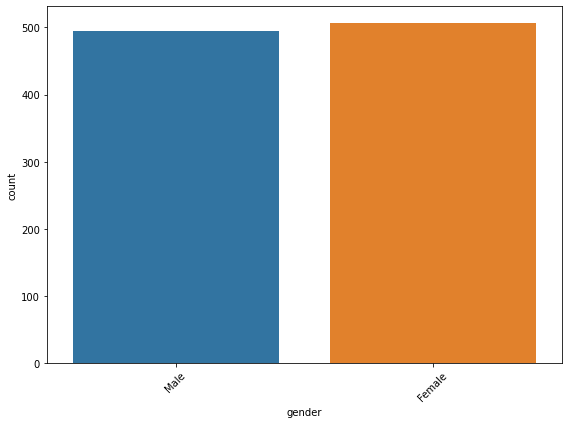

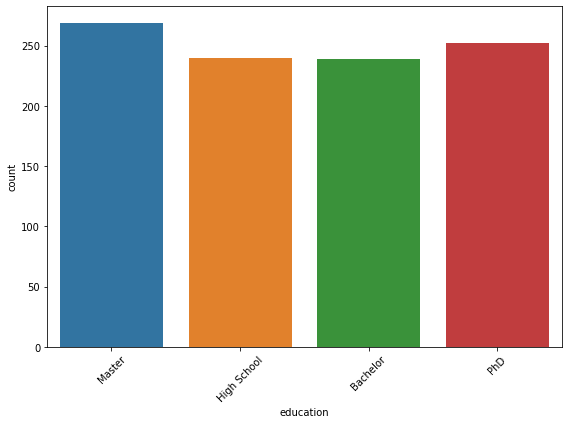

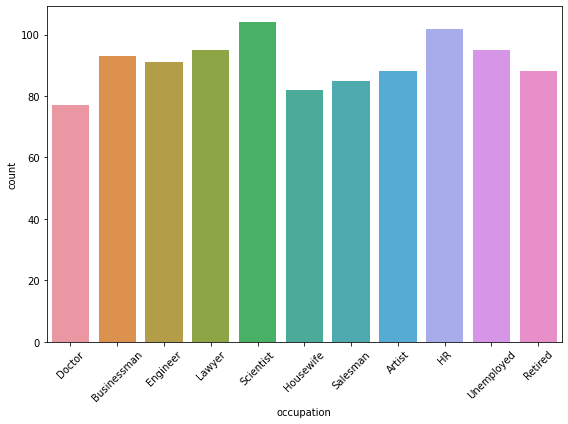

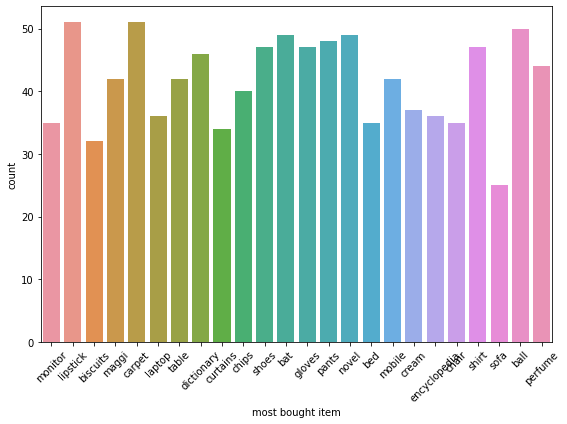

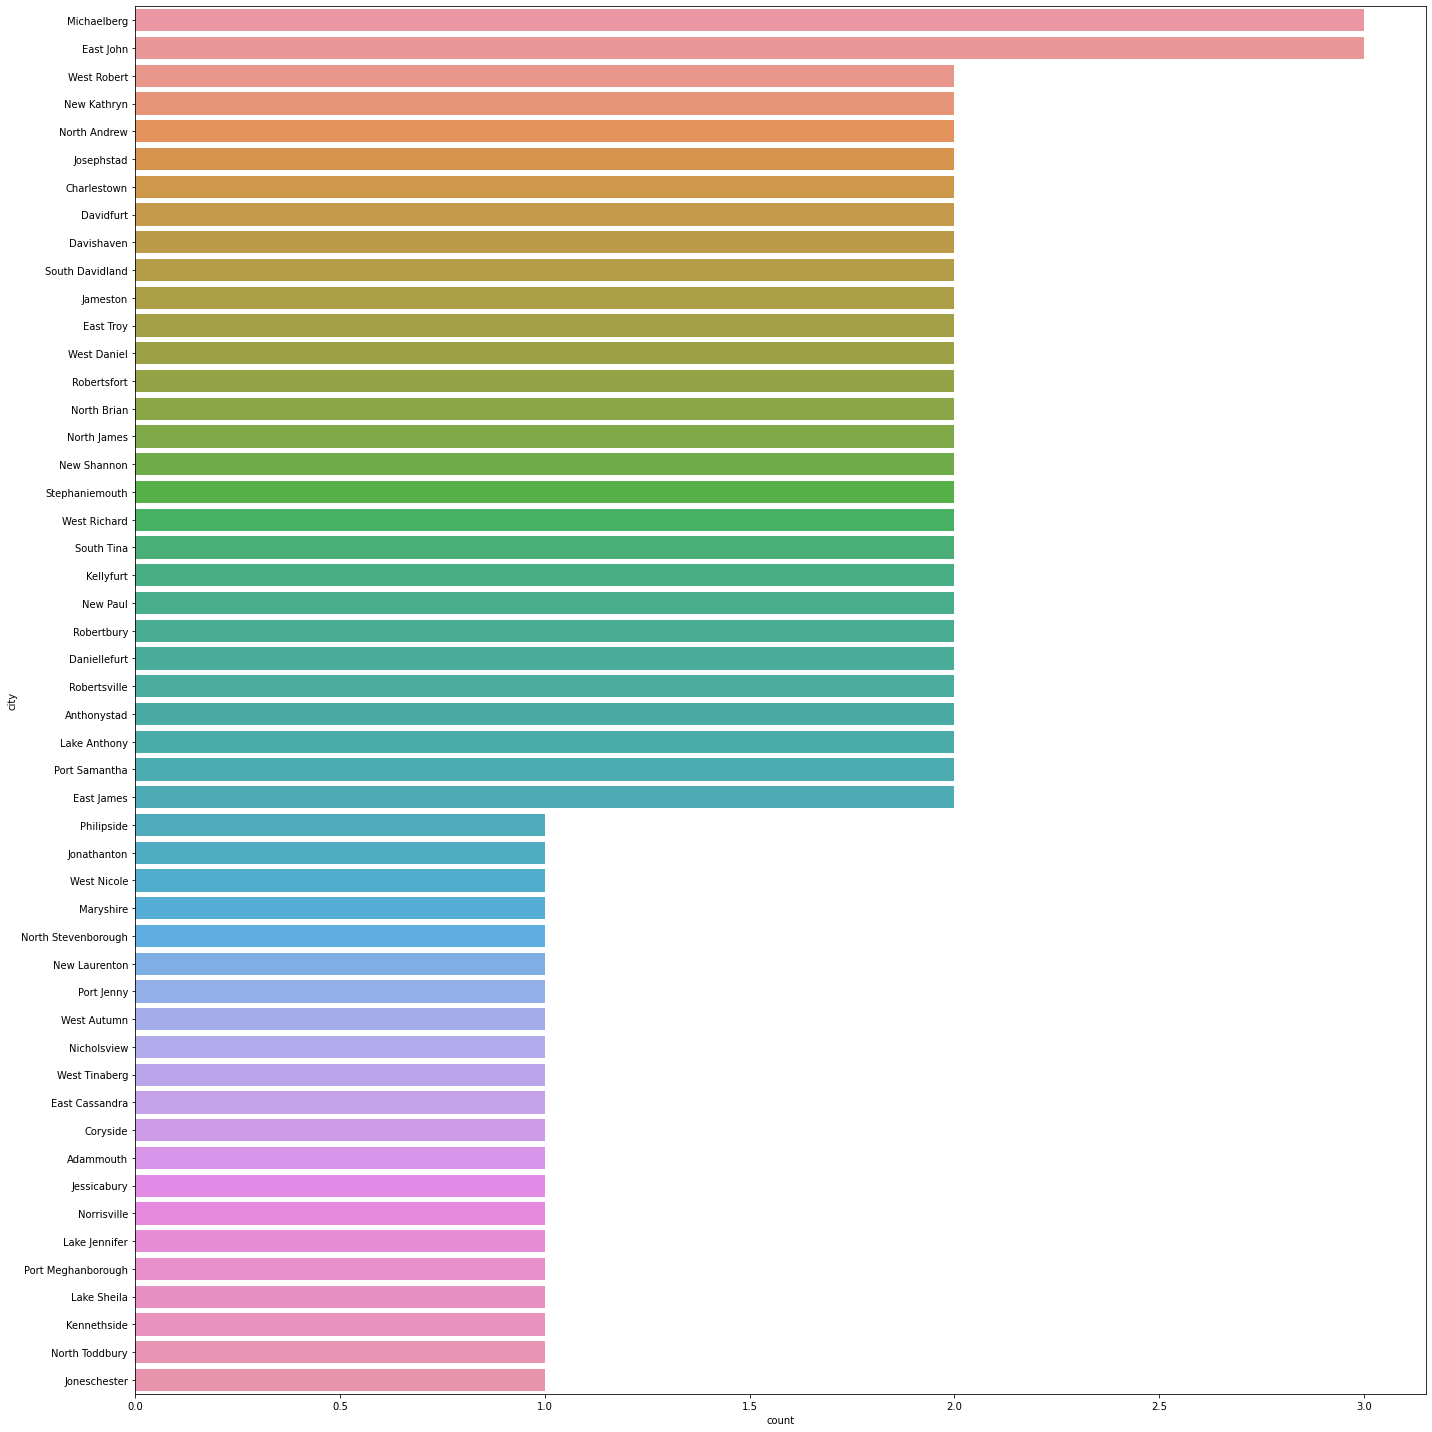

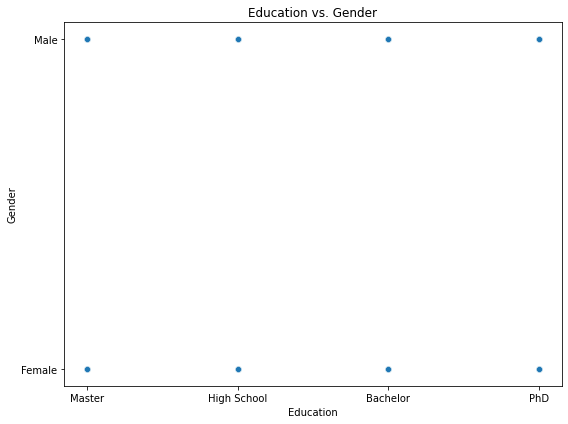

In [88]:
dataset = pd.read_csv('advertisement.csv') # Read the dataset using pandas' read_csv method
y = dataset['labels'].tolist() # labels
X = dataset.drop(columns=['labels']) # features
y = np.array(y)

# DATA EXPLORATION
# Use ChatGPT to extract all types of features: suggested using .select_dtypes method.
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns
bool_features = X.select_dtypes(include=["bool"]).columns

# DATA VISUALIZATION
# Plot histograms for numerical features
X[numerical_features].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Plot bar plots for boolean features
for feature in bool_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=X, x=feature)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
# Plot bar plots for categorical features
for feature in categorical_features:
    if feature == "city":
        continue
    plt.figure(figsize=(8, 6))
    sns.countplot(data=X, x=feature)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

N = 50  # Number of top cities to visualize

# Get the top N most frequent cities as there are many cities.
top_cities = X['city'].value_counts().head(N).index
# Plot horizontal bar plot for top N cities
plt.figure(figsize=(20, 20))
sns.countplot(data=X[X['city'].isin(top_cities)], y='city', order=top_cities)
plt.tight_layout()
plt.show()

# Scatter plot for education vs. gender
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X, x='education', y='gender')
plt.xlabel('Education')
plt.ylabel('Gender')
plt.title('Education vs. Gender')
plt.tight_layout()
plt.show()

In [89]:
# DATA PREPROCESSING

# First convert boolean features to int
X[bool_features] = X[bool_features].astype(int)

# Now converting categorical values into integers, assigning a unique integer to each category via Label Encoding.
# IDEALLY ONE HOT ENCODING is best suited for the given data as it is generally followed when the categories have no natural order.
# But instead Label encoding preferred over one-hot encoding because:
# Using one-hot encoding more than 11 features would have been generated since max_features which can be used to tune
# is 11, one-hot encoding would lead to very less accuracy.
# Preferred over ordinal encoding because:
# Ordinal Encoding is suitable when categorical variables have an inherent order or ranking.
# Although, using either label encoding or ordinal encoding give roughly same hamming loss so using any of these works.

for feature in categorical_features:
    encoder_ = LabelEncoder()
    X[feature] = encoder_.fit_transform(X[feature])

# Now normalize numerical features using StandardScaler method: Numerical features often have varying scales
# and ranges. Normalization (or scaling) is important to ensure that all numerical features contribute
# equally to the learning process. 
# This prevents features with larger scales from dominating the learning process and helps the algorithm
# converge faster during training. Suggestion from ChatGPT.

# DATA FEATURIZATION: Since we can see from the data visualization that the city feature is useless, the max count
# of occurrence across all cities is 3, so we can drop the city column from our data to improvise.

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

X = np.array(X)

# Now convert target labels via MLB
# Multi-label classification involves predicting a binary vector for each instance, 
# where each element in the vector indicates the presence or absence of a label. 
# The MultiLabelBinarizer converts the original label lists into this binary format, making it compatible with 
# multi-label classifiers.
mlb = MultiLabelBinarizer()
y_binarized = mlb.fit_transform([y_label.split() for y_label in y])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized, test_size=0.2, random_state=42)

In [90]:
max_depth = [3,5,10,20,30]
max_features = [3,5,7,9,11]
criterion = ["gini", "entropy"]

dtf_classifier = MLDT()

# clf is Decision Tree Classifier with the Powerset Formulation
# mclf is Decision Tree Classifier with the MultiOutput Formulation

clf = LabelPowerset(classifier = DecisionTreeClassifier())
mclf = MultiOutputClassifier(estimator = DecisionTreeClassifier())

results = []
new_classifier = MLDT()
print("=" * 105)
print("METRICS FOR POWERSET SETTING:")
# Use gpt for printing parameters in a neat and clean format.
print("=" * 85)
print("{:<5} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format("Depth", "Feature", "Criteria", "HammingLoss","accuracy","f1_score", "precision", "recall"))
for depth in max_depth:
    for feature in max_features:
        for criteria in criterion:
            parameters = [depth,feature,criteria]
            dtf_classifier.set_params(depth,feature,criteria)
            dtf_classifier.build_classifier()
            clf = LabelPowerset(classifier = dtf_classifier.classifier)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            hamming_score = hamming_loss(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            class_names = mlb.classes_
            evaluation_report = classification_report(y_test, y_pred, target_names=class_names,zero_division=1)
            f1_score = float(evaluation_report.split()[-2])
            precision = precision_score(y_test, y_pred, average='weighted',zero_division =1)
            recall = recall_score(y_test, y_pred, average='weighted',zero_division =1)
            print("{:<5} {:<10} {:<10} {:<12.3f} {:<10} {:<10} {:<10.3f} {:<10.3f}".format(depth, feature, criteria, hamming_score,accuracy,f1_score, precision, recall))
            results.append((depth, feature, criteria, hamming_score,accuracy,f1_score, precision, recall))
print("=" * 85)

top_performing = sorted(results, key=lambda x: x[5], reverse=True)[:3]

print("Following are the top three performing set of hyperparamters according to F1 Score: ")

for idx, (depth, feature, criteria, hamming_score,accuracy,f1_score, precision, recall) in enumerate(top_performing, start=1):
    print(f"{idx}. Hyperparameters:")
    print(f"   Max Depth: {depth}")
    print(f"   Max Features: {feature}")
    print(f"   Criterion: {criteria}")
    print(f"   F1 Score: {f1_score:.2f}\n")
print("=" * 85)

METRICS FOR POWERSET SETTING:
Depth Feature    Criteria   HammingLoss accuracy   f1_score   precision  recall    
3     3          gini       0.369        0.01       0.25       0.378      0.199     
3     3          entropy    0.358        0.02       0.28       0.656      0.218     
3     5          gini       0.368        0.05       0.34       0.477      0.292     
3     5          entropy    0.297        0.075      0.4        0.727      0.269     
3     7          gini       0.307        0.085      0.4        0.520      0.287     
3     7          entropy    0.292        0.095      0.45       0.674      0.313     
3     9          gini       0.307        0.085      0.4        0.520      0.287     
3     9          entropy    0.280        0.095      0.47       0.722      0.328     
3     11         gini       0.307        0.085      0.4        0.520      0.287     
3     11         entropy    0.280        0.095      0.47       0.722      0.328     
5     3          gini       0.360   

## DECISION TREE MULTIOUPUT CODE BELOW

In [91]:
print("=" * 105)
print("METRICS FOR MULTI-OUTPUT SETTING:")
# Use gpt for printing parameters in a neat and clean format.
print("=" * 85)
print("{:<5} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format("Depth", "Feature", "Criteria", "HammingLoss","accuracy","f1_score", "precision", "recall"))
for depth in max_depth:
    for feature in max_features:
        for criteria in criterion:
            parameters = [depth,feature,criteria]
            dtf_classifier.set_params(depth,feature,criteria)
            dtf_classifier.build_classifier()
            mclf = MultiOutputClassifier(estimator = dtf_classifier.classifier)
            mclf.fit(X_train, y_train)
            y_pred = mclf.predict(X_test)
            hamming_score = hamming_loss(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            class_names = mlb.classes_
            evaluation_report = classification_report(y_test, y_pred, target_names=class_names,zero_division=1)
            f1_score = float(evaluation_report.split()[-2])
            precision = precision_score(y_test, y_pred, average='weighted',zero_division =1)
            recall = recall_score(y_test, y_pred, average='weighted',zero_division =1)
            print("{:<5} {:<10} {:<10} {:<12.3f} {:<10} {:<10} {:<10.3f} {:<10.3f}".format(depth, feature, criteria, hamming_score,accuracy,f1_score, precision, recall))
            results.append((depth, feature, criteria, hamming_score,accuracy,f1_score, precision, recall))
print("=" * 85)

top_performing = sorted(results, key=lambda x: x[5], reverse=True)[:3]

print("Following are the top three performing set of hyperparamters according to F1 Score: ")

for idx, (depth, feature, criteria, hamming_score,accuracy,f1_score, precision, recall) in enumerate(top_performing, start=1):
    print(f"{idx}. Hyperparameters:")
    print(f"   Max Depth: {depth}")
    print(f"   Max Features: {feature}")
    print(f"   Criterion: {criteria}")
    print(f"   F1 Score: {f1_score:.2f}\n")
print("=" * 85)

METRICS FOR MULTI-OUTPUT SETTING:
Depth Feature    Criteria   HammingLoss accuracy   f1_score   precision  recall    
3     3          gini       0.284        0.07       0.31       0.837      0.209     
3     3          entropy    0.302        0.04       0.2        0.736      0.137     
3     5          gini       0.316        0.045      0.2        0.746      0.133     
3     5          entropy    0.304        0.035      0.23       0.635      0.156     
3     7          gini       0.273        0.08       0.36       0.812      0.226     
3     7          entropy    0.271        0.075      0.34       0.877      0.222     
3     9          gini       0.256        0.09       0.41       0.897      0.266     
3     9          entropy    0.259        0.09       0.41       0.895      0.258     
3     11         gini       0.255        0.09       0.4        0.916      0.260     
3     11         entropy    0.255        0.09       0.4        0.916      0.260     
5     3          gini       0.32

In [92]:
# Initialize the k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
print("=" * 105)
print("METRICS FOR POWERSET SETTING:")
print("{:<5} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format("Depth", "Feature", "Criteria", "HammingLoss","accuracy","f1_score", "precision", "recall"))
# print("=" * 85)

hamming_losses_lps = []
hamming_losses_mol = []
accuracies_lps = []
f1_scores_lps = []
precisions_lps = []
recalls_lps = []
accuracies_mol = []
f1_scores_mol = []
precisions_mol = []
recalls_mol = []

depth = 10
feature = 11
criteria = "gini"
# CALCULATE THE KFOLD VALIDATION METRICS FOR MAX DEPTH, MAX FEATURES AND GINI CRITERIA
parameters = [depth, feature, criteria]

dtf_classifier.set_params(depth, feature, criteria)
dtf_classifier.build_classifier()
clf = LabelPowerset(classifier=dtf_classifier.classifier)
mclf = MultiOutputClassifier(estimator = dtf_classifier.classifier)

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    clf.fit(X_train_fold, y_train_fold)
    mclf.fit(X_train_fold, y_train_fold)
    y_pred_fold = clf.predict(X_val_fold)
    y_pred_fold_mol = mclf.predict(X_val_fold)
    
    hamming_loss_fold = hamming_loss(y_val_fold, y_pred_fold)
    hamming_loss_fold_mol = hamming_loss(y_val_fold, y_pred_fold_mol)

    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    accuracy_fold_mol = accuracy_score(y_val_fold, y_pred_fold_mol)

    class_names = mlb.classes_
    evaluation_report = classification_report(y_val_fold, y_pred_fold, target_names=class_names, zero_division=1)
    evaluation_report_mol = classification_report(y_val_fold, y_pred_fold_mol, target_names=class_names, zero_division=1)

    f1_score_fold = float(evaluation_report.split()[-2])
    precision_fold = precision_score(y_val_fold, y_pred_fold, average='weighted', zero_division=1)
    recall_fold = recall_score(y_val_fold, y_pred_fold, average='weighted', zero_division=1)

    f1_score_fold_mol = float(evaluation_report_mol.split()[-2])
    precision_fold_mol = precision_score(y_val_fold, y_pred_fold_mol, average='weighted', zero_division=1)
    recall_fold_mol = recall_score(y_val_fold, y_pred_fold_mol, average='weighted', zero_division=1)

    hamming_losses_lps.append(hamming_loss_fold)
    accuracies_lps.append(accuracy_fold)
    f1_scores_lps.append(f1_score_fold)
    precisions_lps.append(precision_fold)
    recalls_lps.append(recall_fold)

    hamming_losses_mol.append(hamming_loss_fold_mol)
    accuracies_mol.append(accuracy_fold_mol)
    f1_scores_mol.append(f1_score_fold_mol)
    precisions_mol.append(precision_fold_mol)
    recalls_mol.append(recall_fold_mol)

avg_hamming_loss = sum(hamming_losses_lps) / len(hamming_losses_lps)
avg_accuracy = sum(accuracies_lps) / len(accuracies_lps)
avg_f1_score = sum(f1_scores_lps) / len(f1_scores_lps)
avg_precision = sum(precisions_lps) / len(precisions_lps)
avg_recall = sum(recalls_lps) / len(recalls_lps)

avg_hamming_loss_mol = sum(hamming_losses_mol) / len(hamming_losses_mol)
avg_accuracy_mol = sum(accuracies_mol) / len(accuracies_mol)
avg_f1_score_mol = sum(f1_scores_mol) / len(f1_scores_mol)
avg_precision_mol = sum(precisions_mol) / len(precisions_mol)
avg_recall_mol = sum(recalls_mol) / len(recalls_mol)


print("{:<5} {:<10} {:<10} {:<12.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}".format(depth, feature, criteria, avg_hamming_loss, avg_accuracy, avg_f1_score, avg_precision, avg_recall))
print("=" * 85)
print("METRICS FOR MULTIOUTPUT SETTING:")
print("{:<5} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format("Depth", "Feature", "Criteria", "HammingLoss","accuracy","f1_score", "precision", "recall"))
print("{:<5} {:<10} {:<10} {:<12.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}".format(depth, feature, criteria, avg_hamming_loss_mol, avg_accuracy_mol, avg_f1_score_mol, avg_precision_mol, avg_recall_mol))
print("=" * 105)

METRICS FOR POWERSET SETTING:
Depth Feature    Criteria   HammingLoss accuracy   f1_score   precision  recall    
10    11         gini       0.333        0.028      0.498      0.535      0.455     
METRICS FOR MULTIOUTPUT SETTING:
Depth Feature    Criteria   HammingLoss accuracy   f1_score   precision  recall    
10    11         gini       0.319        0.041      0.522      0.561      0.489     
